In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Setup

We initially load query and train images and then detect and compute all their keypoints and descriptors through SIFT descriptor.

In [3]:
query_names = ['0','1','11','19','24','25','26']
train_names = ['scenes/e1.png','scenes/e2.png','scenes/e3.png','scenes/e4.png','scenes/e5.png']

sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher()

LOWE_COEFFICIENT = 0.5
MAX_COLOR_DISTANCE = 50

query_keypoints = []
query_descriptors = []

train_keypoints = []
train_descriptors = []

train_imgs = []
query_imgs = []

train_imgs_bgr = []
query_imgs_bgr = []

for query in query_names:
    query='models/'+query+'.jpg'
    q = cv2.imread(query, 0)
    query_imgs.append(q)
    query_imgs_bgr.append(cv2.imread(query))
    kp, des = sift.detectAndCompute(q, None)
    query_keypoints.append(kp)
    query_descriptors.append(des)

for train in train_names:
    t = cv2.imread(train, 0)
    train_imgs.append(t)
    train_imgs_bgr.append(cv2.imread(train))
    kp, des = sift.detectAndCompute(t, None)
    train_keypoints.append(kp)
    train_descriptors.append(des)

## Functions

### Finding good matches

We write a function to return the good matches. The matcher is a Brute Force matcher using KNN to find the best ones, which then get filtered using LOWE coefficient threshold. The use of FLANN matcher is not necessary here, as we have only few images (we have no time constrains like we would have if analysing a livestream).

In [3]:
def find_good_matches(des_query, des_train, kp_query,kp_train):
    
        matches = bf.knnMatch(des_query, des_train, k=2)
        
        # We will collect the good keypoints in these lists
        
        good_train_kp = []
        good_query_kp = []
        
        for m,n in matches:
            if m.distance < LOWE_COEFFICIENT * n.distance:
                
                # trainIdx and queryIdx are attributes of the Match object
                
                good_train_kp.append(kp_train[m.trainIdx])
                good_query_kp.append(kp_query[m.queryIdx])

        return len(good_query_kp), good_query_kp, good_train_kp

### Drawing boxes in train image

In order to draw the bounding boxes of the found query images in the train image, we use the polylines function from cv2. The query image identifier is drawn at the center of the box itself.

In [4]:
def draw_boxes(found_query_boxes, query_crop_pts, train_img_bgr, query_names):
    
    train_img_rgb = cv2.cvtColor(train_img_bgr, cv2.COLOR_BGR2RGB)
    
    for k,v in found_query_boxes.items():
    
        train_img_rgb = cv2.polylines(train_img_rgb, [np.int32(v)], True, (0,255,0), 3, cv2.LINE_AA)
        center = [int(i) for i in query_crop_pts[k]['center']]
        cv2.putText(train_img_rgb, query_names[k], tuple(center), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,255,0), 10, cv2.LINE_AA)
        
    plt.imshow(train_img_rgb)
    plt.show()

### Checking color consistency

We use color consistency as one criterion to determine if the found query in the train is acceptable, since there could be images that have the same shapes but different colors. The metric used here is Euclidean distance.

In [5]:
def color_consistency(query_img_bgr, train_img_crop):
    
    query_avg_color = query_img_bgr.reshape(-1,3).mean(axis=0)
    train_avg_color = train_img_crop.reshape(-1,3).mean(axis=0)

    color_distance = np.sqrt(sum(v ** 2 for v in (query_avg_color-train_avg_color)))
    
    return color_distance < MAX_COLOR_DISTANCE

### Printing results

We provide a listing of the found query images, along with details of the relationship with the train image.

In [6]:
def print_result(query_crop_pts,found_query_boxes, query_names):
    
    for k,v in query_crop_pts.items():
        if(k in found_query_boxes):
            print('Product '+query_names[k]+' - 1 instance found:')
            width = v['x_max']-v['x_min']
            height = v['y_max']-v['y_min']
            center = [int(i) for i in v['center']] # To cut the many decimal digits
            print('\tInstance 1 {position:'+str(center)+', width:'+str(width)+'px, height:'+str(height)+'px }\n')

## Step A

This is the main part of the program which iterates on every query image for every train image, and report the detected matches.

Product 0 - 1 instance found:
	Instance 1 {position:[162, 214], width:312px, height:442px }

Product 11 - 1 instance found:
	Instance 1 {position:[443, 167], width:301px, height:392px }



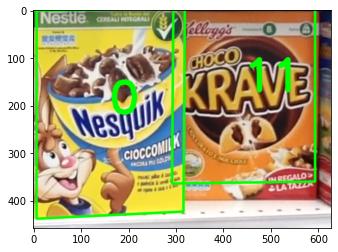

Product 24 - 1 instance found:
	Instance 1 {position:[167, 219], width:339px, height:493px }

Product 25 - 1 instance found:
	Instance 1 {position:[878, 231], width:322px, height:445px }

Product 26 - 1 instance found:
	Instance 1 {position:[538, 218], width:337px, height:488px }



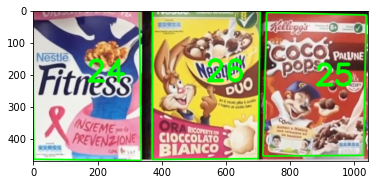

Product 0 - 1 instance found:
	Instance 1 {position:[170, 236], width:328px, height:452px }

Product 11 - 1 instance found:
	Instance 1 {position:[474, 191], width:312px, height:397px }



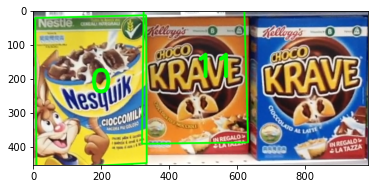

Product 0 - 1 instance found:
	Instance 1 {position:[158, 739], width:327px, height:453px }

Product 11 - 1 instance found:
	Instance 1 {position:[463, 691], width:306px, height:398px }

Product 25 - 1 instance found:
	Instance 1 {position:[556, 281], width:431px, height:603px }

Product 26 - 1 instance found:
	Instance 1 {position:[205, 195], width:345px, height:497px }



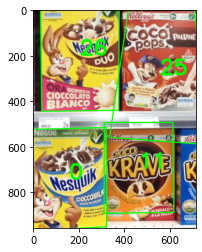

Product 19 - 1 instance found:
	Instance 1 {position:[503, 190], width:300px, height:386px }

Product 25 - 1 instance found:
	Instance 1 {position:[161, 228], width:328px, height:452px }



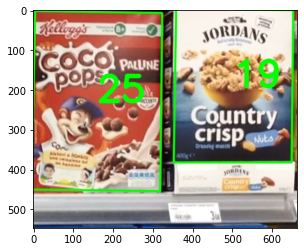

In [7]:
for i,train_img_bgr in enumerate(train_imgs_bgr):
    
    kp_train, des_train = train_keypoints[i], train_descriptors[i]
    
    found_query_boxes = {}
    query_crop_pts = {}
    query_good_matches = {}

    for j,query_img_bgr in enumerate(query_imgs_bgr):
        

        kp_query, des_query = query_keypoints[j], query_descriptors[j]
        
        n_good_matches, good_query_kp, good_train_kp = find_good_matches(des_query, des_train, kp_query,kp_train)
        
        if n_good_matches > 30:
            
            # reshape is used to make boxes compatible with cv2 functions
            
            src_pts = np.float32([kp.pt for kp in good_query_kp]).reshape(-1,1,2)
            dst_pts = np.float32([kp.pt for kp in good_train_kp]).reshape(-1,1,2)
            
            ransac = cv2.RANSAC
            homography, _ = cv2.findHomography(src_pts, dst_pts, ransac, 5.0)
            
            height, width, _ = query_img_bgr.shape
            src_box = np.float32([[0,0],[0,height-1],[width-1,height-1],[width-1,0]]).reshape(-1,1,2)
            dst_box = cv2.perspectiveTransform(src_box, homography).reshape(-1,2)

            height, width, _ = train_img_bgr.shape
            
            center = (sum((dst_box[:,0])/4),sum((dst_box[:,1])/4))
            
            x_min = int(min(dst_box[:,0])) # dst_box[:,0] is all x coordinates
            x_max = int(max(dst_box[:,0]))
            y_min = int(min(dst_box[:,1])) # dst_box[:,1] is all y coordinates
            y_max = int(max(dst_box[:,1]))
            
            train_img_crop = train_img_bgr[max(y_min,0):min(y_max,height),
                                           max(x_min,0):min(x_max,width)]
            
            if color_consistency(query_img_bgr, train_img_crop):
                
                for k, v in query_crop_pts.items():

                    # check if center is in other box or vice versa
                    if (v['center'][0] > x_min and v['center'][0] < x_max\
                        and v['center'][1] > y_min and v['center'][1] < y_max)\
                        or\
                        (center[0] > v['x_min'] and center[0] < v['x_max']\
                        and center[1] > v['y_min'] and center[1] < v['y_max']):
                            if(n_good_matches > query_good_matches[k]):
                                del found_query_boxes[k]
                
                query_good_matches[j] = n_good_matches
                query_crop_pts[j] = {'x_min' : x_min, 'x_max': x_max, 'y_min': y_min, 'y_max': y_max, 'center': center}
                found_query_boxes[j] = dst_box

    # TODO: assicurarsi di tenere solo quelli con più kps
    
    print_result(query_crop_pts,found_query_boxes, query_names)
    draw_boxes(found_query_boxes, query_crop_pts, train_img_bgr, query_names)
            
        